In [35]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, color, segmentation, exposure, img_as_float, feature
from skimage.filters import roberts, sobel, scharr, threshold_otsu, rank, threshold_adaptive
from skimage.util import img_as_ubyte
from skimage.morphology import disk, opening, dilation, closing, erosion, skeletonize, remove_small_objects, white_tophat, black_tophat
from skimage.measure import label

%matplotlib inline

In [36]:
# import screen capture of a sketched geo model and convert it to grayscale

# im=io.imread('wb_small_bodies.png')
# im=io.imread('paper_wedge.png')
# im=io.imread('paper_breaks.png')
im=io.imread('paper_pen_wow.png')

im = color.rgb2gray(im[0:-1:2,0:-1:2])

[]

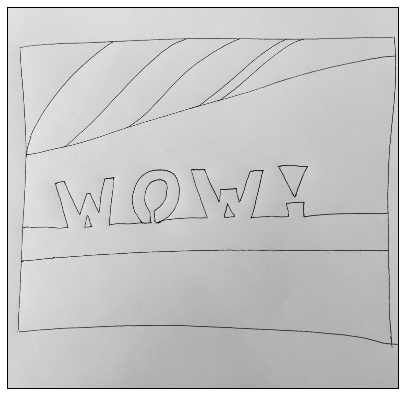

In [37]:
# plot it

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(im, cmap='gray')

ax.set_xticks([])
ax.set_yticks([])

In [38]:
# compressor or limiter (electronics) 
# find hard edges in data with long wavelength variations in amplitude

# (1) square each element in the image to obtain the power function
sqr = im**2

# (2) gaussian of squared image
flt2 = sp.ndimage.filters.gaussian_filter(sqr,21)

# (3) divide the intensity of each original pixel by the square root of the smoothed square
cmprs= im/(np.sqrt(flt2))

[]

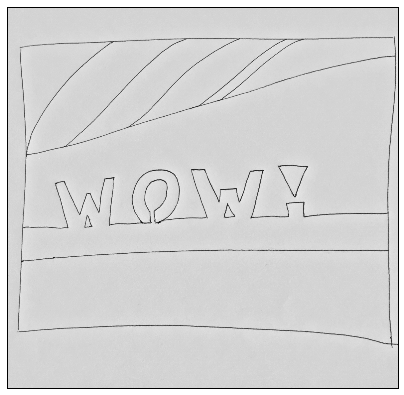

In [39]:
# plot it

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(cmprs, cmap='gray')

ax.set_xticks([])
ax.set_yticks([])

In [40]:
# contrast stretching
p2, p98 = np.percentile(cmprs, (2, 98))
rescale = exposure.rescale_intensity(cmprs, in_range=(p2, p98))

[]

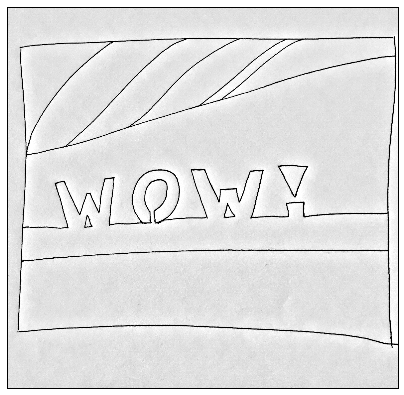

In [41]:
# plot it

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(rescale, cmap='gray')

ax.set_xticks([])
ax.set_yticks([])

In [42]:
# binarize image with scalar threshold
binary = ~(color.rgb2gray(rescale) > 0.5)

[]

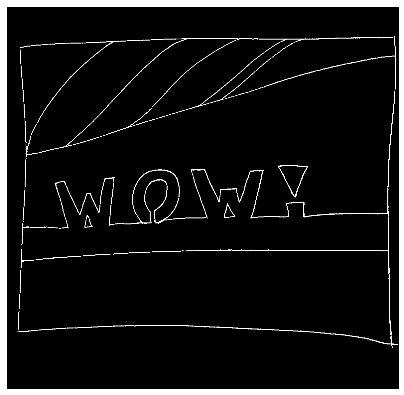

In [43]:
# plot it

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(binary, cmap='gray')

ax.set_xticks([])
ax.set_yticks([])

In [44]:
# get the average width of the edges in pixels

# sum binary map to get total area of edges
a = np.sum(binary)

# skeletonize and sum the skeleton to get total length of edges
sk = skeleton_th=skeletonize(binary)
l = np.sum(sk)

w= a/l

w

3

In [45]:
# using morphology.remove_small_objects to eliminate both small bright and dark spots

# calculate size of a square object of size similar to the average width of edges
selem= disk(w*2)
obsz = np.sum(selem)

removed = remove_small_objects(binary,obsz)
removed = ~remove_small_objects(~removed,obsz)

In [46]:
# now that the noise has been removed, get a more representative value for average width of the edges in pixels

# sum binary map to get total area of edges
aprime = np.sum(removed)

# skeletonize and sum the skeleton to get total length of edges
skprime = skeleton_th=skeletonize(removed)
lprime = np.sum(skprime)

w= aprime/lprime

w

3

[]

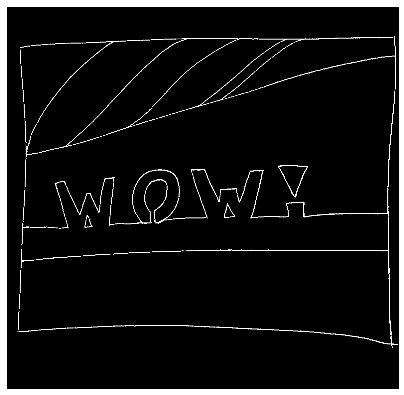

In [47]:
# plot it

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(removed, cmap='gray')

ax.set_xticks([])
ax.set_yticks([])

In [48]:
# prompt user for number of bodies in sketch
# after it is entered, select manually next cell before running it
N = int(raw_input('Enter number of geological bodies: '))

Enter number of geological bodies: 9


In [49]:
# clear the objects connected to the image border (in this case just the outside white rim)
clean_border = segmentation.clear_border(removed)

# label objects in the cleared image
all_labels, n = label(clean_border, return_num=True)


[]

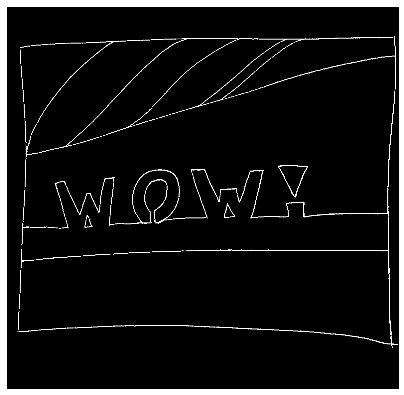

In [50]:
# plot it

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(clean_border, cmap='gray')

ax.set_xticks([])
ax.set_yticks([])

In [51]:
# this part connects disconnected edge segments
dilated = clean_border
n1=n
count = 0

# while the number of labeled objects is less than the number of bodies the user input 
# (accounts for outside body and edge body itself being labeled)
# dilate by 1 pixel and label again (recursively) 
while n1<(N+2):
    dilated = dilation(dilated, disk(1))
    dilated_labels, n1 = label(dilated, return_num=True)
    count +=1


# dilation - fills black holes in edges and connects edge segments
# erosion - thins dilated edges
# making an assumtion that bodies would not be thinner than somewhere in the neighborhood of w
dilated = dilation(clean_border, disk((count+w)/2))
eroded = erosion(dilated, disk((count+w)/2))

[]

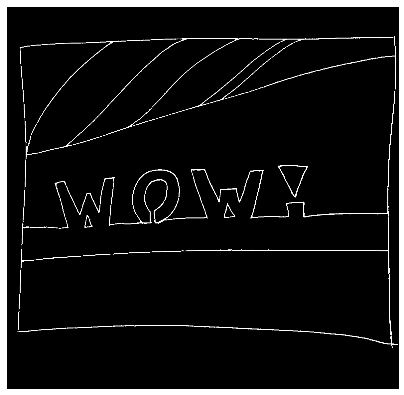

In [52]:
# plot it

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(eroded, cmap='gray')

ax.set_xticks([])
ax.set_yticks([])

In [53]:
# skeletonize and dilate to get final boundaries
edges = skeleton_th=skeletonize(eroded)
openedsk = ~dilation(edges,disk(3))

[]

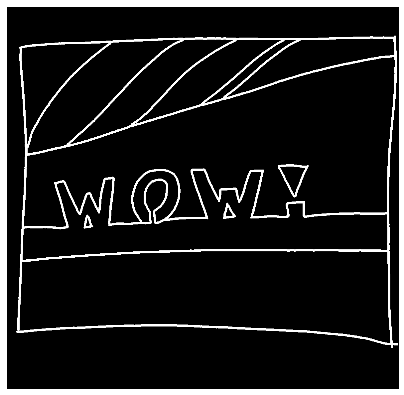

In [54]:
# plot it

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(~openedsk, cmap='gray')

ax.set_xticks([])
ax.set_yticks([])

In [55]:
# clear the objects connected to the image border (in this case just the outside rim)
clean_border1 = segmentation.clear_border(openedsk)

In [56]:
# label objects in the cleared image
all_labels1, n2 = label(clean_border1, return_num=True)
n2

19

[]

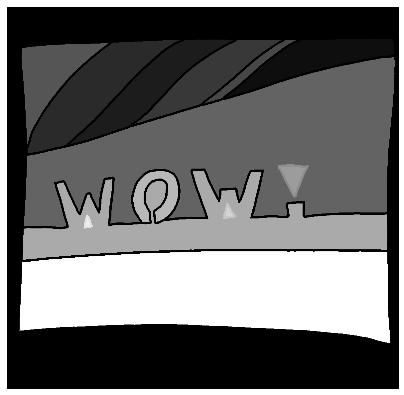

In [57]:
# plot it

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(all_labels1, cmap='gray')

ax.set_xticks([])
ax.set_yticks([])


In [58]:
# autocrop by eliminating all empty rows and columns on the outside of the image 

non_empty_columns = np.where(all_labels1.max(axis=0)>0)[0]
non_empty_rows = np.where(all_labels1.max(axis=1)>0)[0]

cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), 
           max(non_empty_columns))

cropped = all_labels1[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1 ]

# cropped a first time apply trigonometric relationship sin(A) * hypotenuse = opposite to calculate the extra 
# amount of cropping to acocunt for non straight border
# making an assumption that most people can draw a line to within 5 degrees of horizontal/vertical

m= min(cropped.shape)
sn=np.sin(5. * np.pi / 180.)
cr=m*sn
cr

# final cropping
cropBox = (min(non_empty_rows)+cr, max(non_empty_rows)-cr, min(non_empty_columns)+cr, 
           max(non_empty_columns)-cr)
cropped = all_labels1[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1]

[]

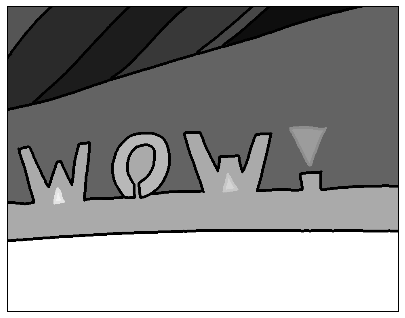

In [59]:
# plot it

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(cropped, cmap='gray')

ax.set_xticks([])
ax.set_yticks([])


In [60]:
dilated = dilation(cropped, disk(w))
interim = dilation(cropped, disk(w))

[]

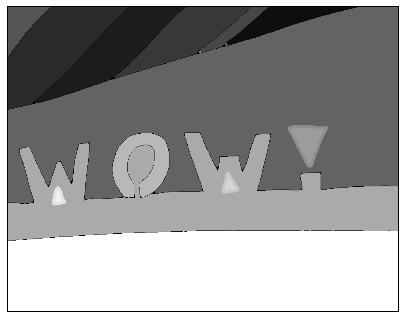

In [61]:
# plot it

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(dilated,  cmap='gray')

ax.set_xticks([])
ax.set_yticks([])


In [62]:
def closest(x,y, pixels, offset, best_colours):
    """
    Recursively finds the nearest colour in an image
    from a set of colours given a pixel.

    :param x: The x coordinate of the pixel.
    :param y: The y coordinate of the pixel
    :param offset: The offset to use to the search space.
    :param best_colours: List/Tuple of allowable colours

    :returns: the nearest colour from the best colours set
    """

    if pixels[x,y] in best_colours:
        return pixels[x,y]

    x_low = np.amax((0,x - offset))
    x_high = np.amin((x + offset, pixels.shape[0]-1))
    y_low = np.amax((0,y - offset))
    y_high = np.amin((y + offset, pixels.shape[1]-1))

    x_index = np.concatenate((np.ones(y_high-y_low) * x_low,
                              np.arange(x_low, x_high),
                              np.ones(y_high-y_low) * x_high,
                              np.arange(x_low, x_high)))

    y_index = \
      np.concatenate((np.arange(y_low,y_high,dtype='int'),
                      np.ones(x_high-x_low,dtype='int')*y_high,
                      np.arange(y_low,y_high,dtype='int'),
                      np.ones(x_high-x_low, dtype='int')*y_low))


    data = pixels[x_index.astype('int'),
                  y_index.astype('int')].flatten()

    counts = np.empty_like(best_colours)
    for i, col in enumerate(best_colours):
        counts[i] = (data==col).sum()

    if (counts.sum()==0):
        return closest(x, y, pixels, offset + 1, best_colours)

    return best_colours[np.argmax(counts)]


In [63]:
# ??? why does "for x,y in zip(...)" alter dilated ???
# This causes the algorithm to provide unexpected results, "dragging" color as it interpolates. 
# I generated an intermediate variable which is to be identical to "dilated": "interim".
# When I explicitly define "interim = dilated", interim is altered along with dilated.
# When I define interim using the same expression as dilated, interim is no longer
# altered with dilated.


# find locations of borders between bodies - e.g. value is zero ~= color  black
# replace those values with the value of the closest body
# using, again, the number of bodies, N, input by the user
newest = dilated
index = np.array(np.where(dilated == 0))

for x,y in zip(index[0], index[1]):
    newest[x,y] = closest(x,y, interim, w/4, np.arange(n2)+1) # changed "cr" to "w/4", "N" to "n2"

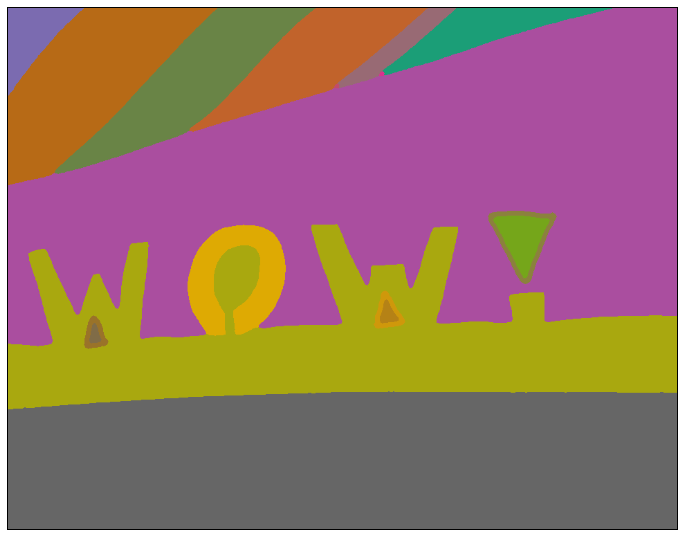

In [64]:
# plot and save as .png

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(newest, cmap='Dark2')

ax.set_xticks([])
ax.set_yticks([])

plt.savefig('model.png',dpi=300, bbox_inches='tight', pad_inches=0)
